# Training stage 1

#### *Note before starting: 
`ImageCleaner` does not work in JupyterLab, but it *does* work in Jupyter Notebook

In [1]:
from fastai.vision import *
from fastai.widgets import *

In [2]:
np.random.seed(22)

In [3]:
path = Path('data')

Create DataBunch `.from_csv` to include the cleaned up data set. <br>
Use transforms to augment the data.

In [4]:
tfms = get_transforms(max_rotate=25., max_zoom=1.25, max_lighting=0.4, max_warp=0.3, p_affine=0.85)

In [5]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


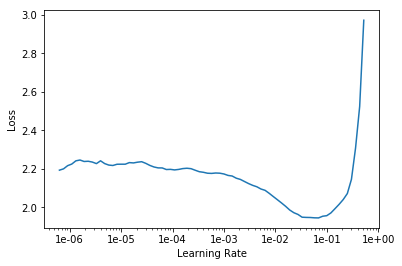

In [7]:
learn.lr_find()
learn.recorder.plot()

Train final layer exclusively

In [8]:
learn.fit_one_cycle(10, max_lr=2e-2)

epoch,train_loss,valid_loss,error_rate,time
0,2.061785,1.643095,0.691489,00:06
1,1.873345,1.847116,0.654255,00:05
2,1.774457,2.264091,0.712766,00:05
3,1.708067,2.149113,0.686170,00:05
4,1.674133,1.800851,0.643617,00:05
5,1.612366,1.481977,0.542553,00:05
6,1.538493,1.727588,0.643617,00:05
7,1.465212,1.567751,0.569149,00:05
8,1.384258,1.512905,0.473404,00:05
9,1.311658,1.447020,0.468085,00:05


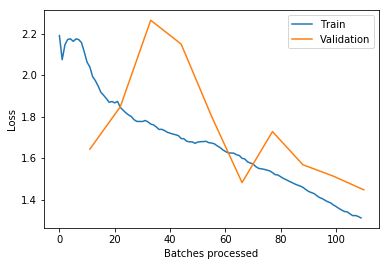

In [9]:
learn.recorder.plot_losses()

In [10]:
# Saves weights in data/models
learn.save('res34-stage-1')

# Training stage 2

### Train all layers

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


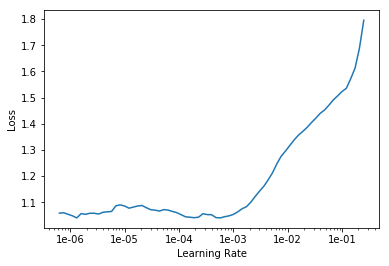

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(10, max_lr=slice(1e-4,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.056806,1.448988,0.452128,00:06
1,1.059201,1.440472,0.473404,00:06
2,1.025590,1.568286,0.521277,00:06
3,0.993490,1.592884,0.505319,00:06
4,0.938518,1.376986,0.478723,00:06
5,0.876601,1.394910,0.494681,00:06
6,0.824041,1.388158,0.494681,00:06
7,0.765870,1.328087,0.452128,00:06
8,0.715782,1.305607,0.473404,00:06
9,0.680019,1.300618,0.489362,00:06


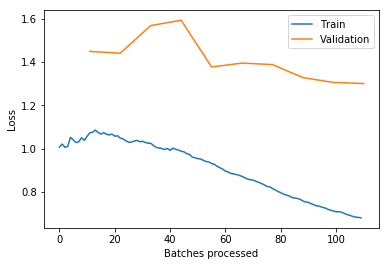

In [14]:
learn.recorder.plot_losses()

In [15]:
learn.save('res34-stage-2')

# Interpretation

In [20]:
# learn.load('res34-stage-2');

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

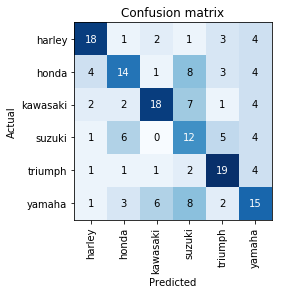

In [17]:
interp.plot_confusion_matrix()

# Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

####  `ImageCleaner` does not work in JupyterLab, but it does work in Jupyter Notebook

Note that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

#### First the Validation Set:

In [18]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [19]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

#### Now the Training Set:

In [21]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Train)

In [23]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

---
---
# New Architecture - Training stage 1

#### Recreate the ImageDataBunch from the `cleaned.csv` to include the changes

Since the `cleaned.csv` file has changed, we will not end up with the exact same train/valid split. Therefore, our current model will have already been trained on images that will be in the new validation set. 

Let's start with a fresh learner with resnet50 architecture and see if the results improve.

In [20]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


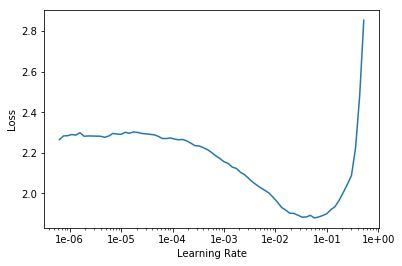

In [22]:
learn.lr_find()
learn.recorder.plot()

Train final layer exclusively

In [23]:
learn.fit_one_cycle(10, max_lr=2e-2)

epoch,train_loss,valid_loss,error_rate,time
0,2.232390,1.872907,0.706667,00:09
1,1.901111,3.361119,0.786667,00:07
2,1.815074,2.515676,0.746667,00:07
3,1.737102,3.067418,0.760000,00:07
4,1.683403,4.440708,0.760000,00:07
5,1.616908,2.128825,0.706667,00:07
6,1.529482,1.649576,0.606667,00:07
7,1.433579,1.531950,0.586667,00:07
8,1.340255,1.437265,0.526667,00:07
9,1.265307,1.341864,0.540000,00:07


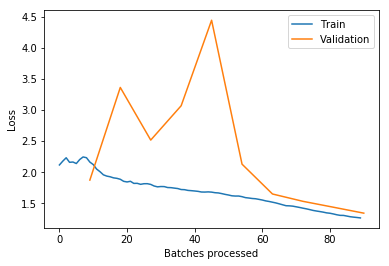

In [24]:
learn.recorder.plot_losses()

In [25]:
learn.save('res50-stage-1')

# Training stage 2

### Train all layers

In [26]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


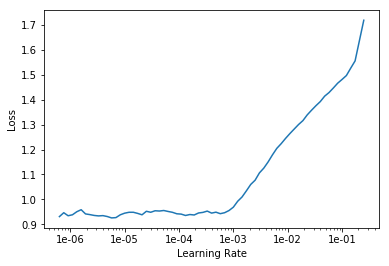

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.977472,1.315590,0.540000,00:09
1,0.971196,1.297580,0.520000,00:09
2,0.970641,1.277062,0.520000,00:09
3,0.946961,1.256898,0.520000,00:09
4,0.915585,1.251516,0.520000,00:09
5,0.897871,1.256844,0.493333,00:09
6,0.885804,1.258802,0.520000,00:09
7,0.866086,1.254738,0.520000,00:09
8,0.851456,1.262435,0.513333,00:09
9,0.853864,1.262697,0.500000,00:09


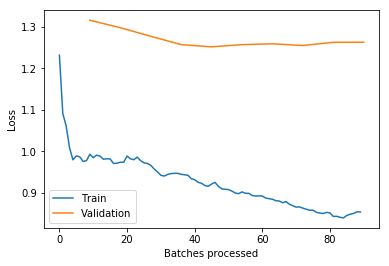

In [29]:
learn.recorder.plot_losses()

In [30]:
learn.save('res50-stage-2')

# Interpretation - ResNet50

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

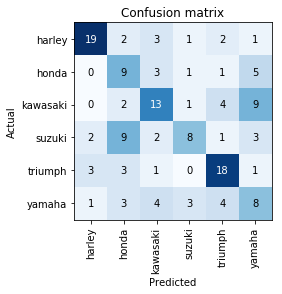

In [32]:
interp.plot_confusion_matrix()